In [1]:
# =============================
# 0. Install Required Packages
# =============================
!pip install sentence-transformers xgboost optuna shap textstat scikit-learn matplotlib seaborn textblob pandas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, re, optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sentence_transformers import SentenceTransformer
import xgboost as xgb
import shap

warnings.filterwarnings('ignore')

In [3]:
# If you use Japanese, switch default model to E5-multilingual-base!
DEFAULT_EMBEDDING_MODEL = 'intfloat/multilingual-e5-base'  # Strong for Japanese/English
# Alternative: 'all-MiniLM-L6-v2' for English only

class BusinessInsightExtractor:
    def __init__(self):
        self.aspects = {
            'fit': ['fit', 'size', 'tight', 'loose', 'small', 'large', 'sizing'],
            'quality': ['quality', 'material', 'fabric', 'cheap', 'durable', 'well-made'],
            'style': ['style', 'color', 'design', 'fashionable', 'trendy', 'cute'],
            'comfort': ['comfort', 'comfortable', 'soft', 'breathable', 'cozy'],
            'price': ['price', 'expensive', 'cheap', 'value', 'worth', 'cost'],
            'shipping': ['shipping', 'delivery', 'arrived', 'fast', 'slow', 'package']
        }

    def generate_business_recommendations(self, df):
        print("\n=== BUSINESS INSIGHTS & RECOMMENDATIONS ===")

        # Aspect analysis
        for aspect in self.aspects.keys():
            aspect_col = f'aspect_{aspect}'
            if aspect_col in df.columns:
                aspect_mentions = df[aspect_col].sum()
                negative_mentions = df[(df[aspect_col]) & (df['sentiment'] == 'negative')].shape[0]
                if aspect_mentions > 0:
                    negative_rate = negative_mentions / aspect_mentions * 100
                    print(f"• {aspect.upper()}: {aspect_mentions} mentions, {negative_rate:.1f}% negative")

        print("\n=== KEY RECOMMENDATIONS ===")
        print("• Monitor fit-related complaints for sizing improvements")
        print("• Focus on quality control to reduce material complaints")
        print("• Analyze price sensitivity in negative reviews")

        return {"status": "completed"}

def executive_summary(df):
    print("\n=== EXECUTIVE SUMMARY ===")
    total_reviews = len(df)
    sentiment_dist = df['sentiment'].value_counts(normalize=True) * 100

    print(f"Total Reviews Analyzed: {total_reviews:,}")
    print("Sentiment Distribution:")
    for sentiment, pct in sentiment_dist.items():
        print(f"  • {sentiment.capitalize()}: {pct:.1f}%")

    avg_rating = df['rating'].mean()
    print(f"Average Rating: {avg_rating:.2f}/5")

def plot_overall_sentiment(df):
    plt.figure(figsize=(10, 6))

    # Sentiment distribution
    plt.subplot(1, 2, 1)
    sentiment_counts = df['sentiment'].value_counts()
    colors = ['#ff6b6b', '#ffd93d', '#6bcf7f']
    plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%',
            colors=colors, startangle=90)
    plt.title('Sentiment Distribution')

    # Rating distribution
    plt.subplot(1, 2, 2)
    plt.hist(df['rating'], bins=5, color='skyblue', alpha=0.7, edgecolor='black')
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    plt.title('Rating Distribution')
    plt.xticks(range(1, 6))

    plt.tight_layout()
    plt.show()

def plot_negative_aspect_breakdown(df):
    aspects = ['fit', 'quality', 'style', 'comfort', 'price', 'shipping']
    negative_counts = []

    for aspect in aspects:
        aspect_col = f'aspect_{aspect}'
        if aspect_col in df.columns:
            count = df[(df[aspect_col]) & (df['sentiment'] == 'negative')].shape[0]
            negative_counts.append(count)
        else:
            negative_counts.append(0)

    plt.figure(figsize=(10, 6))
    bars = plt.bar(aspects, negative_counts, color='#ff6b6b', alpha=0.7)
    plt.title('Negative Sentiment by Aspect')
    plt.xlabel('Aspects')
    plt.ylabel('Number of Negative Reviews')
    plt.xticks(rotation=45)

    # Add value labels on bars
    for bar, count in zip(bars, negative_counts):
        if count > 0:
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                    str(count), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

def plot_aspect_sentiment_heatmap(df):
    aspects = ['fit', 'quality', 'style', 'comfort', 'price', 'shipping']
    sentiments = ['negative', 'neutral', 'positive']

    # Create heatmap data
    heatmap_data = []
    for aspect in aspects:
        aspect_col = f'aspect_{aspect}'
        row = []
        for sentiment in sentiments:
            if aspect_col in df.columns:
                count = df[(df[aspect_col]) & (df['sentiment'] == sentiment)].shape[0]
                row.append(count)
            else:
                row.append(0)
        heatmap_data.append(row)

    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap_data,
                xticklabels=sentiments,
                yticklabels=aspects,
                annot=True,
                fmt='d',
                cmap='RdYlBu_r',
                cbar_kws={'label': 'Number of Reviews'})
    plt.title('Aspect-Sentiment Heatmap')
    plt.xlabel('Sentiment')
    plt.ylabel('Aspects')
    plt.tight_layout()
    plt.show()

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, re, optuna
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import shap

warnings.filterwarnings('ignore')

class ABSAXGBoostTabularPipeline:
    def __init__(self, max_train_samples=8000, max_test_samples=2000, n_splits=5):
        self.label_encoder = LabelEncoder()
        self.insight_extractor = BusinessInsightExtractor()
        self.max_train_samples = max_train_samples
        self.max_test_samples = max_test_samples
        self.n_splits = n_splits
        self.aspect_cols = []

    def load_and_preprocess_data(self):
        try:
            from datasets import load_dataset
            print("Loading real dataset...")
            ds = load_dataset("Censius-AI/ECommerce-Women-Clothing-Reviews")
            df = pd.DataFrame(ds["train"])
        except Exception as e:
            print(f"Error loading dataset: {e}")
            print("Creating synthetic dataset for demonstration...")
            np.random.seed(42)
            n_samples = 1000
            reviews = [
                "Great fit and comfortable to wear",
                "Poor quality material, very disappointed",
                "Love the style and color",
                "Too expensive for the quality",
                "Perfect size, fits well",
                "Shipping was very slow",
                "Beautiful design and good fabric",
                "Not worth the price",
                "Comfortable and stylish",
                "Material feels cheap"
            ]
            synthetic_data = []
            for i in range(n_samples):
                review = np.random.choice(reviews)
                rating = np.random.randint(1, 6)
                synthetic_data.append({
                    'review_text': review + f" (Review {i+1})",
                    'rating': rating
                })
            df = pd.DataFrame(synthetic_data)

        df.columns = [col.strip().replace(' ', '_').lower() for col in df.columns]
        df = df.dropna(subset=['review_text'])
        df = df.sample(frac=1, random_state=42).reset_index(drop=True)
        train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['rating'])
        train_df = train_df.head(self.max_train_samples)
        test_df = test_df.head(self.max_test_samples)
        def create_sentiment_label(rating):
            if rating <= 2:
                return 'negative'
            elif rating == 3:
                return 'neutral'
            else:
                return 'positive'
        train_df['sentiment'] = train_df['rating'].apply(create_sentiment_label)
        test_df['sentiment'] = test_df['rating'].apply(create_sentiment_label)
        return train_df, test_df

    def extract_aspects(self, df):
        aspects = self.insight_extractor.aspects
        aspect_cols = []
        for aspect, keywords in aspects.items():
            pattern = '|'.join([re.escape(kw) for kw in keywords])
            colname = f'aspect_{aspect}'
            df[colname] = df['review_text'].str.lower().str.contains(pattern, na=False, regex=True).astype(int)
            aspect_cols.append(colname)
        self.aspect_cols = aspect_cols
        return df

    def compute_sample_weights(self, y):
        classes = np.unique(y)
        class_counts = np.bincount(y)
        total = len(y)
        weights = np.zeros_like(y, dtype=float)
        for idx, cls in enumerate(classes):
            weights[y == cls] = total / (len(classes) * class_counts[cls])
        return weights

    def fit(self):
        print("Starting ABSA XGBoost (Tabular Only, No Embeddings) Pipeline...")
        train_df, test_df = self.load_and_preprocess_data()
        train_df = self.extract_aspects(train_df)
        test_df = self.extract_aspects(test_df)
        executive_summary(train_df)
        plot_overall_sentiment(train_df)
        plot_negative_aspect_breakdown(train_df)
        plot_aspect_sentiment_heatmap(train_df)
        insights = self.insight_extractor.generate_business_recommendations(train_df)

        y = self.label_encoder.fit_transform(train_df['sentiment'])
        y_test = self.label_encoder.transform(test_df['sentiment'])

        X = train_df[self.aspect_cols].values
        X_test = test_df[self.aspect_cols].values
        feature_names = self.aspect_cols

        skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        train_idx, val_idx = next(skf.split(X, y))
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        weights_train = self.compute_sample_weights(y_train)

        def objective(trial):
            param = {
                "objective": "multi:softprob",
                "num_class": 3,
                "eval_metric": "mlogloss",
                "max_depth": trial.suggest_int("max_depth", 3, 10),
                "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
                "n_estimators": trial.suggest_int("n_estimators", 50, 300),
                "subsample": trial.suggest_float("subsample", 0.6, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
                "gamma": trial.suggest_float("gamma", 0, 2),
                "lambda": trial.suggest_float("lambda", 1e-4, 10.0, log=True),
                "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
                "tree_method": "auto",
                "use_label_encoder": False,
                "verbosity": 0,
            }
            model = xgb.XGBClassifier(**param)
            model.fit(X_train, y_train, sample_weight=weights_train)
            preds = np.argmax(model.predict_proba(X_val), axis=1)
            return 1.0 - accuracy_score(y_val, preds)
        print("Optuna tuning (on first fold)...")
        study = optuna.create_study(direction="minimize")
        study.optimize(objective, n_trials=10)
        best_params = study.best_trial.params
        best_params.update({"objective": "multi:softprob", "num_class": 3, "use_label_encoder": False, "tree_method": "auto"})
        print("Best params:", best_params)

        # Cross-validation
        oof_preds = np.zeros((len(y), 3))
        cv_acc, cv_prec, cv_rec, cv_f1 = [], [], [], []
        for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            print(f"Fold {fold+1}/{self.n_splits}...")
            X_tr, X_val = X[train_idx], X[val_idx]
            y_tr, y_val = y[train_idx], y[val_idx]
            weights = self.compute_sample_weights(y_tr)
            model = xgb.XGBClassifier(**best_params)
            model.fit(X_tr, y_tr, sample_weight=weights)
            val_pred = np.argmax(model.predict_proba(X_val), axis=1)
            oof_preds[val_idx] = model.predict_proba(X_val)
            acc = accuracy_score(y_val, val_pred)
            prec, rec, f1, _ = precision_recall_fscore_support(y_val, val_pred, average='weighted', zero_division=0)
            cv_acc.append(acc)
            cv_prec.append(prec)
            cv_rec.append(rec)
            cv_f1.append(f1)
            print(f"  Fold acc: {acc:.4f}, prec: {prec:.4f}, rec: {rec:.4f}, f1: {f1:.4f}")
        print("\n=== Cross-Validation Results ===")
        print(f"Accuracy: {np.mean(cv_acc):.4f} ± {np.std(cv_acc):.4f}")
        print(f"Precision: {np.mean(cv_prec):.4f} ± {np.std(cv_prec):.4f}")
        print(f"Recall: {np.mean(cv_rec):.4f} ± {np.std(cv_rec):.4f}")
        print(f"F1: {np.mean(cv_f1):.4f} ± {np.std(cv_f1):.4f}")

        # Final model, all train
        sample_weights = self.compute_sample_weights(y)
        final_model = xgb.XGBClassifier(**best_params)
        final_model.fit(X, y, sample_weight=sample_weights)
        preds = np.argmax(final_model.predict_proba(X_test), axis=1)

        print("\nTest Results (on hold-out set):")
        print(classification_report(y_test, preds, target_names=self.label_encoder.classes_))
        acc = accuracy_score(y_test, preds)
        prec, rec, f1, _ = precision_recall_fscore_support(y_test, preds, average='weighted')
        print(f"\nAccuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

        # Confusion Matrix
        plt.figure(figsize=(5, 4))
        cm = confusion_matrix(y_test, preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.label_encoder.classes_)
        disp.plot(cmap="Blues")
        plt.title("Confusion Matrix (Test)")
        plt.show()

        # SHAP Feature Importance
        try:
            explainer = shap.TreeExplainer(final_model)
            shap_values = explainer.shap_values(X_test)
            plt.figure(figsize=(8, 4))
            shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)
            plt.title("SHAP Feature Importance (Aspect Features Only)")
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"SHAP visualization error: {e}")
            shap_values = None

        # XGBoost feature importance (as table)
        importances = final_model.feature_importances_
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values(by="importance", ascending=False)
        print("\nTop Features by XGBoost Importance:")
        print(importance_df.head(10))

        # Save results for BI/visualization (optional)
        test_df["predicted_sentiment"] = self.label_encoder.inverse_transform(preds)
        return {
            "model": final_model,
            "label_encoder": self.label_encoder,
            "test_df": test_df,
            "train_df": train_df,
            "feature_importance": importance_df,
            "shap_values": shap_values,
            "feature_names": feature_names,
            "cv_accuracy": cv_acc,
            "cv_precision": cv_prec,
            "cv_recall": cv_rec,
            "cv_f1": cv_f1
        }


Starting ABSA XGBoost (Tabular Only, No Embeddings) Pipeline...
Loading real dataset...



=== EXECUTIVE SUMMARY ===
Total Reviews Analyzed: 8,000
Sentiment Distribution:
  • Positive: 76.8%
  • Neutral: 12.4%
  • Negative: 10.8%
Average Rating: 4.18/5


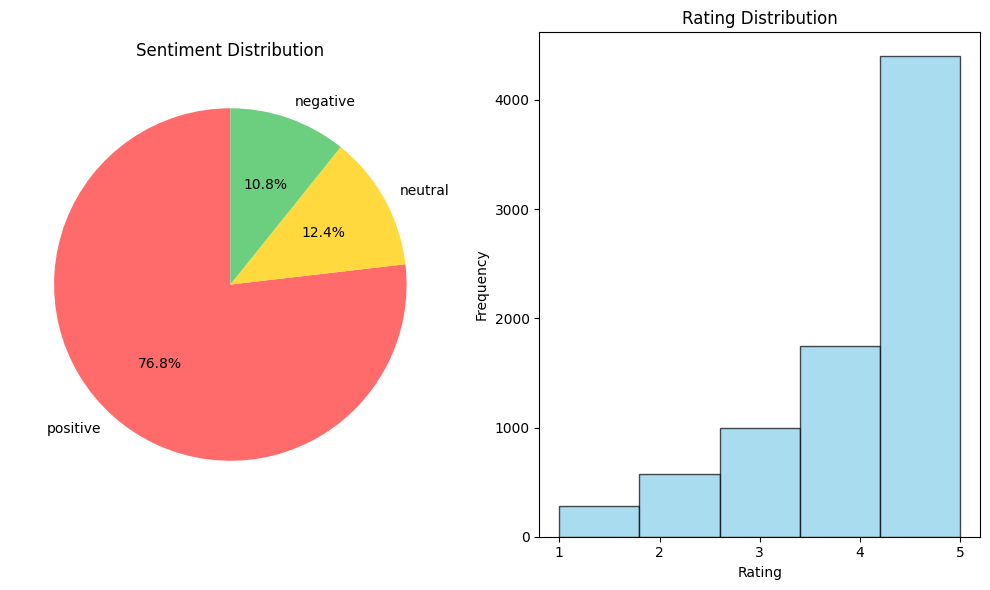

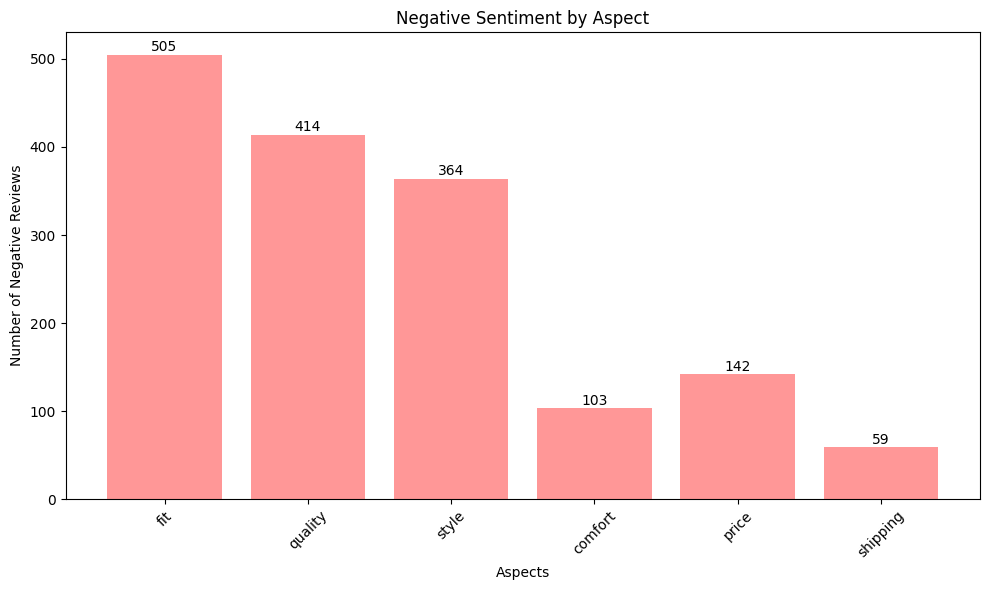

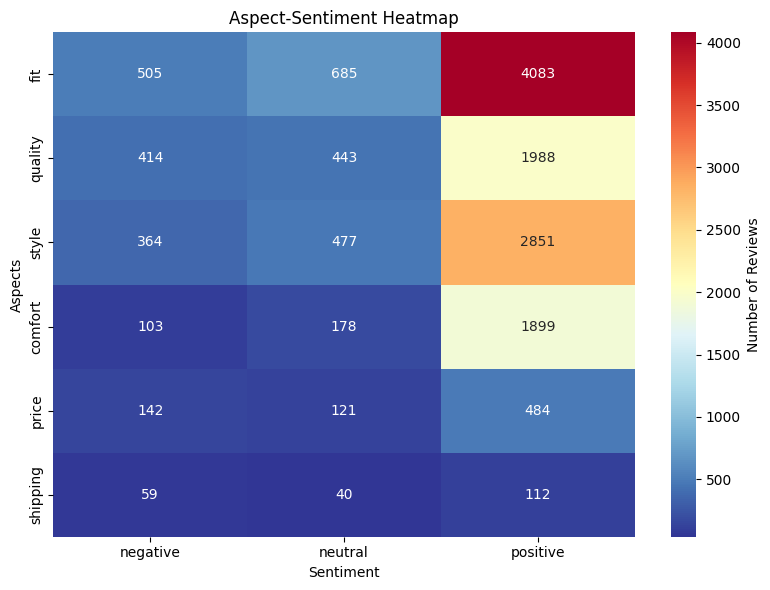

[I 2025-07-03 17:14:12,049] A new study created in memory with name: no-name-f374fea4-b4e6-418f-8e1f-dc4100c6fa8e


[I 2025-07-03 17:14:12,094] Trial 0 finished with value: 0.51625 and parameters: {'max_depth': 4, 'learning_rate': 0.015475468861466423, 'n_estimators': 64, 'subsample': 0.8895851257706364, 'colsample_bytree': 0.745067676906423, 'gamma': 1.8892216799089554, 'lambda': 0.002364451899646709, 'min_child_weight': 5}. Best is trial 0 with value: 0.51625.


[I 2025-07-03 17:14:12,137] Trial 1 finished with value: 0.46125000000000005 and parameters: {'max_depth': 3, 'learning_rate': 0.0019347701525085394, 'n_estimators': 77, 'subsample': 0.7081015275402025, 'colsample_bytree': 0.8461987149369266, 'gamma': 1.0179413706064169, 'lambda': 0.00016442388466649424, 'min_child_weight': 10}. Best is trial 1 with value: 0.46125000000000005.



=== BUSINESS INSIGHTS & RECOMMENDATIONS ===
• FIT: 5273 mentions, 9.6% negative
• QUALITY: 2845 mentions, 14.6% negative
• STYLE: 3692 mentions, 9.9% negative
• COMFORT: 2180 mentions, 4.7% negative
• PRICE: 747 mentions, 19.0% negative
• SHIPPING: 211 mentions, 28.0% negative

=== KEY RECOMMENDATIONS ===
• Monitor fit-related complaints for sizing improvements
• Focus on quality control to reduce material complaints
• Analyze price sensitivity in negative reviews
Optuna tuning (on first fold)...


[I 2025-07-03 17:14:12,307] Trial 2 finished with value: 0.4625 and parameters: {'max_depth': 8, 'learning_rate': 0.0008142075349063225, 'n_estimators': 269, 'subsample': 0.8193081799763827, 'colsample_bytree': 0.922320314311212, 'gamma': 1.23404955122525, 'lambda': 0.9427977036980714, 'min_child_weight': 1}. Best is trial 1 with value: 0.46125000000000005.


[I 2025-07-03 17:14:12,403] Trial 3 finished with value: 0.45125000000000004 and parameters: {'max_depth': 6, 'learning_rate': 0.0026328388045636503, 'n_estimators': 157, 'subsample': 0.7187675172557979, 'colsample_bytree': 0.9525378760586409, 'gamma': 0.9653071635889812, 'lambda': 0.13331344566172842, 'min_child_weight': 6}. Best is trial 3 with value: 0.45125000000000004.


[I 2025-07-03 17:14:12,496] Trial 4 finished with value: 0.515 and parameters: {'max_depth': 4, 'learning_rate': 0.0003088812890843844, 'n_estimators': 199, 'subsample': 0.7771856713852948, 'colsample_bytree': 0.7454732099649977, 'gamma': 1.584546500233825, 'lambda': 0.00553888864342788, 'min_child_weight': 4}. Best is trial 3 with value: 0.45125000000000004.


[I 2025-07-03 17:14:12,648] Trial 5 finished with value: 0.5125 and parameters: {'max_depth': 7, 'learning_rate': 0.00018842062773838112, 'n_estimators': 295, 'subsample': 0.9748660096564895, 'colsample_bytree': 0.8302841091607474, 'gamma': 0.7454423500157998, 'lambda': 0.0001606180054006953, 'min_child_weight': 7}. Best is trial 3 with value: 0.45125000000000004.


[I 2025-07-03 17:14:12,715] Trial 6 finished with value: 0.4625 and parameters: {'max_depth': 3, 'learning_rate': 0.0027314916855936387, 'n_estimators': 140, 'subsample': 0.6019129257691486, 'colsample_bytree': 0.7483375706338015, 'gamma': 0.5748252536962943, 'lambda': 1.5246066082037049, 'min_child_weight': 6}. Best is trial 3 with value: 0.45125000000000004.


[I 2025-07-03 17:14:12,837] Trial 7 finished with value: 0.4625 and parameters: {'max_depth': 6, 'learning_rate': 0.00016575425770749125, 'n_estimators': 214, 'subsample': 0.8304100781353955, 'colsample_bytree': 0.8855777587307443, 'gamma': 1.0725388817551942, 'lambda': 1.4510321487241655, 'min_child_weight': 3}. Best is trial 3 with value: 0.45125000000000004.


[I 2025-07-03 17:14:12,973] Trial 8 finished with value: 0.4625 and parameters: {'max_depth': 9, 'learning_rate': 0.000669738239942139, 'n_estimators': 226, 'subsample': 0.847168087947676, 'colsample_bytree': 0.8940146421444881, 'gamma': 1.420457653636055, 'lambda': 0.0025330063978503637, 'min_child_weight': 1}. Best is trial 3 with value: 0.45125000000000004.


[I 2025-07-03 17:14:13,009] Trial 9 finished with value: 0.51625 and parameters: {'max_depth': 10, 'learning_rate': 0.00030047135702034684, 'n_estimators': 82, 'subsample': 0.9119664088002757, 'colsample_bytree': 0.6065944946015014, 'gamma': 1.3535567421129722, 'lambda': 0.002825387055094639, 'min_child_weight': 2}. Best is trial 3 with value: 0.45125000000000004.


Best params: {'max_depth': 6, 'learning_rate': 0.0026328388045636503, 'n_estimators': 157, 'subsample': 0.7187675172557979, 'colsample_bytree': 0.9525378760586409, 'gamma': 0.9653071635889812, 'lambda': 0.13331344566172842, 'min_child_weight': 6, 'objective': 'multi:softprob', 'num_class': 3, 'use_label_encoder': False, 'tree_method': 'auto'}
Fold 1/5...
  Fold acc: 0.5487, prec: 0.6774, rec: 0.5487, f1: 0.5967
Fold 2/5...


  Fold acc: 0.4963, prec: 0.6740, rec: 0.4963, f1: 0.5542
Fold 3/5...
  Fold acc: 0.5112, prec: 0.6923, rec: 0.5112, f1: 0.5692
Fold 4/5...
  Fold acc: 0.5575, prec: 0.6669, rec: 0.5575, f1: 0.6002
Fold 5/5...


  Fold acc: 0.4456, prec: 0.6740, rec: 0.4456, f1: 0.5079

=== Cross-Validation Results ===
Accuracy: 0.5119 ± 0.0402
Precision: 0.6769 ± 0.0084
Recall: 0.5119 ± 0.0402
F1: 0.5656 ± 0.0335

Test Results (on hold-out set):
              precision    recall  f1-score   support

    negative       0.15      0.37      0.22       188
     neutral       0.17      0.34      0.23       279
    positive       0.82      0.53      0.64      1533

    accuracy                           0.49      2000
   macro avg       0.38      0.42      0.36      2000
weighted avg       0.67      0.49      0.55      2000


Accuracy: 0.4885, Precision: 0.6690, Recall: 0.4885, F1: 0.5460


<Figure size 500x400 with 0 Axes>

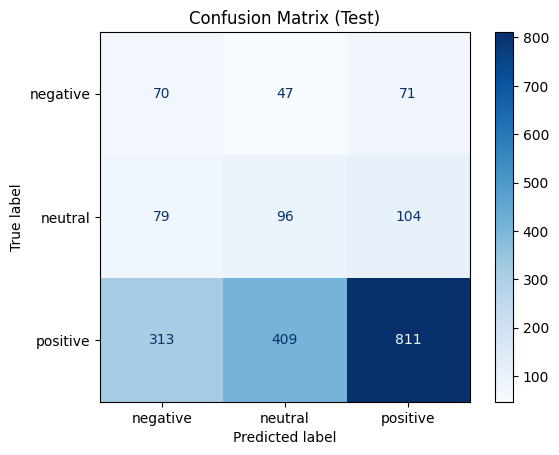

SHAP visualization error: only integer scalar arrays can be converted to a scalar index

Top Features by XGBoost Importance:
           feature  importance
3   aspect_comfort    0.499507
1   aspect_quality    0.184092
4     aspect_price    0.099284
5  aspect_shipping    0.090257
0       aspect_fit    0.081285
2     aspect_style    0.045576


<Figure size 800x400 with 0 Axes>

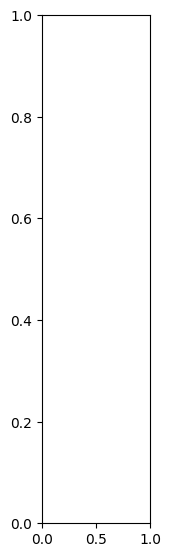

In [5]:
# =========================
# Main
# =========================

# Usage example
if __name__ == "__main__":
    pipeline = ABSAXGBoostTabularPipeline()
    results = pipeline.fit()

Starting ABSA XGBoost (Tabular Features Only) Pipeline...
Loading dataset from Hugging Face...


Successfully loaded 23486 reviews from Hugging Face
Extracting comprehensive features and TF-IDF...


Extracting comprehensive features and TF-IDF...



=== EXECUTIVE SUMMARY ===
Total Reviews Analyzed: 8,000
Sentiment Distribution:
  • Positive: 76.8%
  • Neutral: 12.4%
  • Negative: 10.8%
Average Rating: 4.18/5


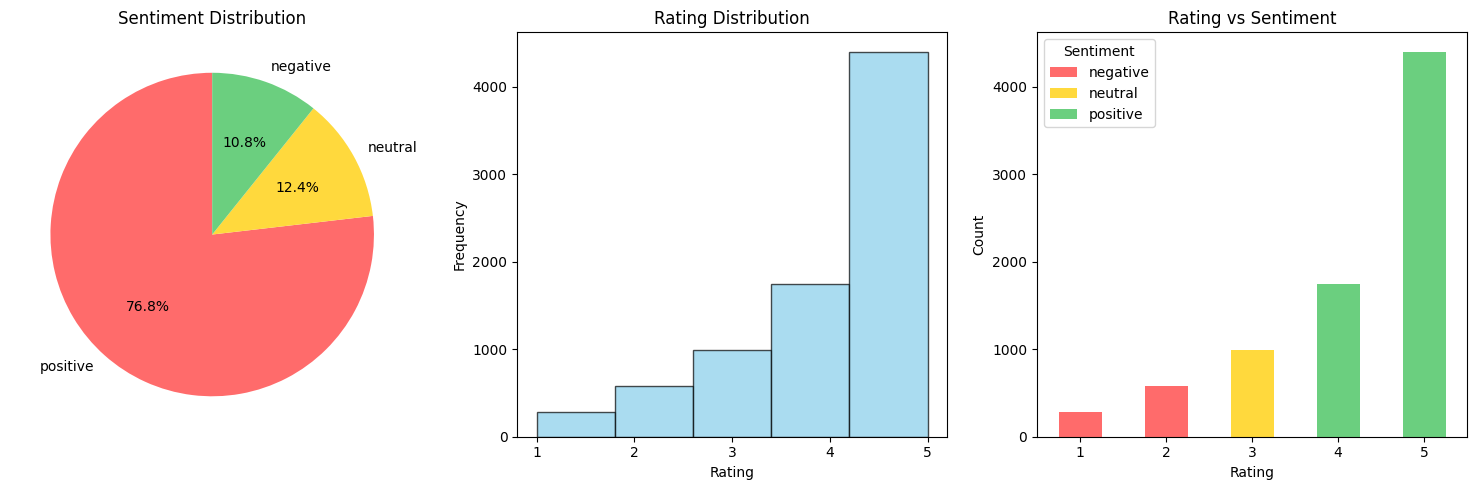

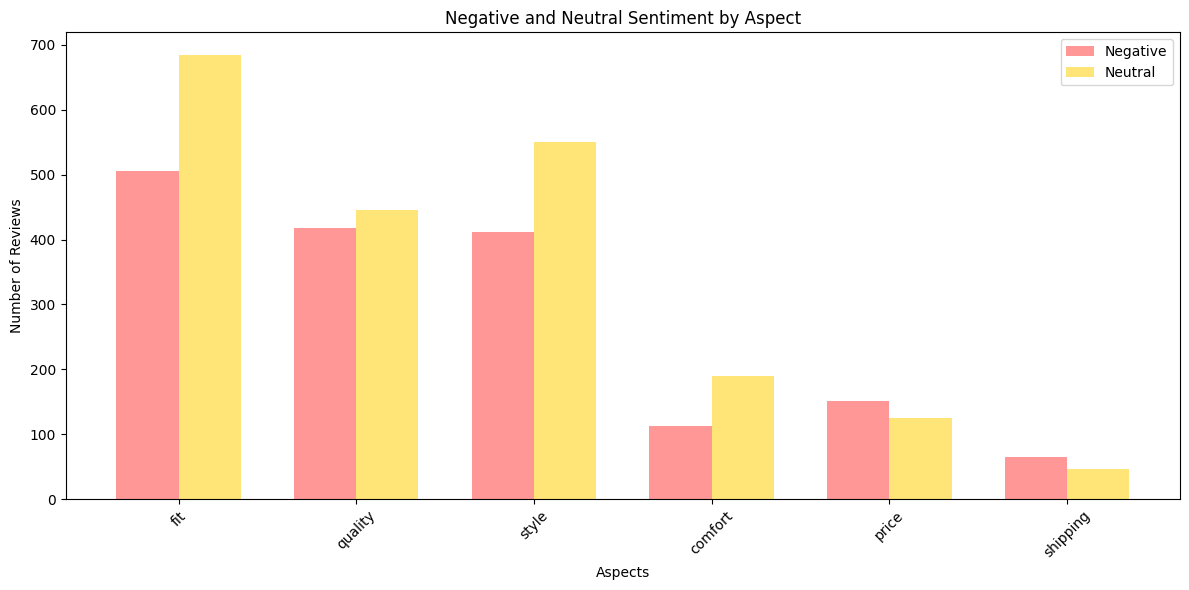

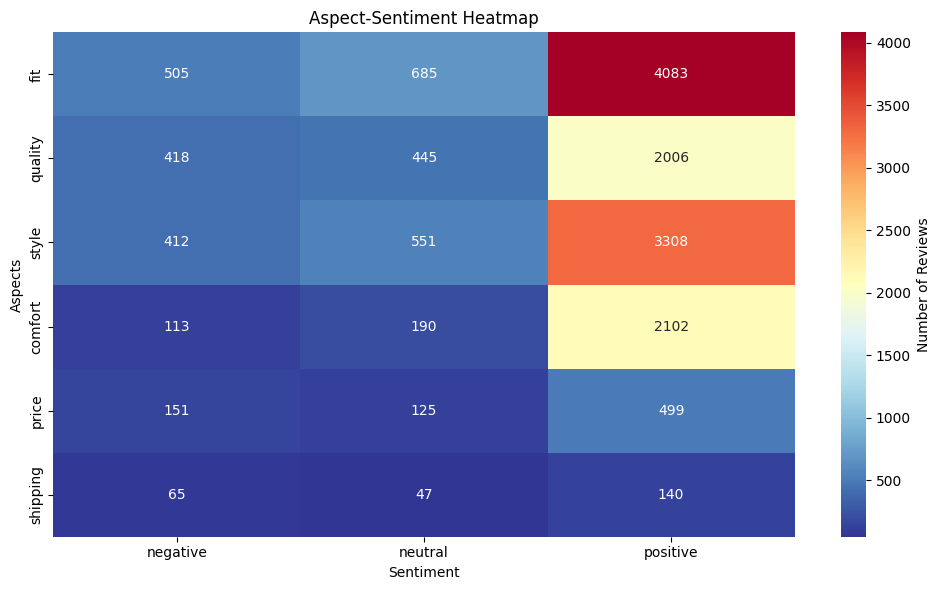

[I 2025-07-03 17:14:26,204] A new study created in memory with name: no-name-9a42ee3f-6d03-4f3a-b793-91fbbcee3274



=== BUSINESS INSIGHTS & RECOMMENDATIONS ===
• FIT: 5273 mentions, 9.6% negative, 13.0% neutral
• QUALITY: 2869 mentions, 14.6% negative, 15.5% neutral
• STYLE: 4271 mentions, 9.6% negative, 12.9% neutral
• COMFORT: 2405 mentions, 4.7% negative, 7.9% neutral
• PRICE: 775 mentions, 19.5% negative, 16.1% neutral
• SHIPPING: 252 mentions, 25.8% negative, 18.7% neutral
Optuna tuning (optimizing for weighted F1 score)...


[I 2025-07-03 17:14:26,783] Trial 0 finished with value: 0.018044468455092222 and parameters: {'max_depth': 5, 'learning_rate': 0.01593554751518231, 'n_estimators': 352, 'subsample': 0.8831486002647471, 'colsample_bytree': 0.7454557184881563, 'gamma': 1.3087972439698892, 'lambda': 0.003376224617224104, 'alpha': 0.005818836127779933, 'min_child_weight': 2}. Best is trial 0 with value: 0.018044468455092222.


[I 2025-07-03 17:14:27,016] Trial 1 finished with value: 0.018033685908001806 and parameters: {'max_depth': 7, 'learning_rate': 0.04648549979933227, 'n_estimators': 166, 'subsample': 0.9790112640593818, 'colsample_bytree': 0.9156534669050576, 'gamma': 2.703818072760006, 'lambda': 2.1106822103290335, 'alpha': 1.140000347734803, 'min_child_weight': 4}. Best is trial 1 with value: 0.018033685908001806.


[I 2025-07-03 17:14:27,429] Trial 2 finished with value: 0.017445739644699643 and parameters: {'max_depth': 6, 'learning_rate': 0.03494303825288017, 'n_estimators': 294, 'subsample': 0.7418235210827665, 'colsample_bytree': 0.9681340737944204, 'gamma': 1.8844591692791473, 'lambda': 0.58593411568915, 'alpha': 0.44288714380843835, 'min_child_weight': 2}. Best is trial 2 with value: 0.017445739644699643.


[I 2025-07-03 17:14:27,743] Trial 3 finished with value: 0.018065798733286398 and parameters: {'max_depth': 8, 'learning_rate': 0.03955822517000291, 'n_estimators': 356, 'subsample': 0.9614951561564915, 'colsample_bytree': 0.7843467766989219, 'gamma': 4.175354970739498, 'lambda': 0.004053749609184115, 'alpha': 2.9863582182774278, 'min_child_weight': 6}. Best is trial 2 with value: 0.017445739644699643.


[I 2025-07-03 17:14:28,359] Trial 4 finished with value: 0.018033685908001806 and parameters: {'max_depth': 6, 'learning_rate': 0.012991365372949946, 'n_estimators': 453, 'subsample': 0.9444134457193999, 'colsample_bytree': 0.9463413419557999, 'gamma': 1.8905367570757037, 'lambda': 0.016134369059706756, 'alpha': 6.717093601020472, 'min_child_weight': 5}. Best is trial 2 with value: 0.017445739644699643.


[I 2025-07-03 17:14:28,654] Trial 5 finished with value: 0.016829847069090964 and parameters: {'max_depth': 7, 'learning_rate': 0.036789325744128444, 'n_estimators': 138, 'subsample': 0.7880081345577006, 'colsample_bytree': 0.7093593742255346, 'gamma': 1.1162387396497475, 'lambda': 0.1362592485528145, 'alpha': 0.016834990474315758, 'min_child_weight': 1}. Best is trial 5 with value: 0.016829847069090964.


[I 2025-07-03 17:14:28,914] Trial 6 finished with value: 0.01866916595517043 and parameters: {'max_depth': 4, 'learning_rate': 0.028456432187398743, 'n_estimators': 182, 'subsample': 0.8131986604194732, 'colsample_bytree': 0.9713481390808454, 'gamma': 2.108221049954972, 'lambda': 0.9032935876774935, 'alpha': 0.0035980344858680957, 'min_child_weight': 2}. Best is trial 5 with value: 0.016829847069090964.


[I 2025-07-03 17:14:29,188] Trial 7 finished with value: 0.01802909711642764 and parameters: {'max_depth': 5, 'learning_rate': 0.14661818711318744, 'n_estimators': 331, 'subsample': 0.7555814743630427, 'colsample_bytree': 0.8429118054286687, 'gamma': 2.28841231054955, 'lambda': 0.02920198975616408, 'alpha': 0.021483567414255965, 'min_child_weight': 5}. Best is trial 5 with value: 0.016829847069090964.


[I 2025-07-03 17:14:29,540] Trial 8 finished with value: 0.01803633673172267 and parameters: {'max_depth': 7, 'learning_rate': 0.07145568134399566, 'n_estimators': 462, 'subsample': 0.893095574080178, 'colsample_bytree': 0.8751434946327725, 'gamma': 2.663543735902907, 'lambda': 0.011048965294030056, 'alpha': 0.0021550010039213287, 'min_child_weight': 6}. Best is trial 5 with value: 0.016829847069090964.


[I 2025-07-03 17:14:30,019] Trial 9 finished with value: 0.01742487191330544 and parameters: {'max_depth': 3, 'learning_rate': 0.12812833102768129, 'n_estimators': 478, 'subsample': 0.873189071512236, 'colsample_bytree': 0.8646095800138129, 'gamma': 0.38236199760379674, 'lambda': 0.03599460877696051, 'alpha': 0.0043911095588738324, 'min_child_weight': 5}. Best is trial 5 with value: 0.016829847069090964.


[I 2025-07-03 17:14:30,493] Trial 10 finished with value: 0.015621171868291817 and parameters: {'max_depth': 8, 'learning_rate': 0.22800941395606453, 'n_estimators': 109, 'subsample': 0.7998683368780531, 'colsample_bytree': 0.7173997883798273, 'gamma': 0.03885954873924646, 'lambda': 0.1754114561308011, 'alpha': 0.07902299877453045, 'min_child_weight': 1}. Best is trial 10 with value: 0.015621171868291817.


[I 2025-07-03 17:14:30,666] Trial 11 finished with value: 0.016850379798872273 and parameters: {'max_depth': 8, 'learning_rate': 0.23151440525544678, 'n_estimators': 108, 'subsample': 0.8054516542730026, 'colsample_bytree': 0.7018803349666328, 'gamma': 0.5056129330813959, 'lambda': 0.18796774120013976, 'alpha': 0.07148018484449721, 'min_child_weight': 1}. Best is trial 10 with value: 0.015621171868291817.


[I 2025-07-03 17:14:30,957] Trial 12 finished with value: 0.01620889436994044 and parameters: {'max_depth': 7, 'learning_rate': 0.08014449052874942, 'n_estimators': 116, 'subsample': 0.7092324183908844, 'colsample_bytree': 0.7144139478660845, 'gamma': 0.0652971392262276, 'lambda': 0.18405539436550872, 'alpha': 0.1253053884249022, 'min_child_weight': 1}. Best is trial 10 with value: 0.015621171868291817.


[I 2025-07-03 17:14:31,348] Trial 13 finished with value: 0.01496148917139406 and parameters: {'max_depth': 8, 'learning_rate': 0.2941097234840394, 'n_estimators': 236, 'subsample': 0.7025330039761325, 'colsample_bytree': 0.7885099497358371, 'gamma': 0.014912028132650093, 'lambda': 4.2193974215090675, 'alpha': 0.1916976269037381, 'min_child_weight': 3}. Best is trial 13 with value: 0.01496148917139406.


[I 2025-07-03 17:14:31,539] Trial 14 finished with value: 0.018033685908001806 and parameters: {'max_depth': 8, 'learning_rate': 0.2519432379447938, 'n_estimators': 236, 'subsample': 0.7002361000335069, 'colsample_bytree': 0.7953447441588963, 'gamma': 3.6876107726085863, 'lambda': 9.372740868529005, 'alpha': 0.2229851576971451, 'min_child_weight': 3}. Best is trial 13 with value: 0.01496148917139406.


[I 2025-07-03 17:14:31,765] Trial 15 finished with value: 0.016797832761592524 and parameters: {'max_depth': 8, 'learning_rate': 0.29511274758999695, 'n_estimators': 233, 'subsample': 0.8323774971192434, 'colsample_bytree': 0.7718460915307158, 'gamma': 1.012456936363401, 'lambda': 8.704166486235634, 'alpha': 0.04422079771522341, 'min_child_weight': 3}. Best is trial 13 with value: 0.01496148917139406.


[I 2025-07-03 17:14:31,964] Trial 16 finished with value: 0.019281789717546793 and parameters: {'max_depth': 6, 'learning_rate': 0.14866841814930315, 'n_estimators': 221, 'subsample': 0.7682779543742762, 'colsample_bytree': 0.8188188694279391, 'gamma': 4.908902814082348, 'lambda': 2.0701762608937373, 'alpha': 0.541187702293336, 'min_child_weight': 3}. Best is trial 13 with value: 0.01496148917139406.


[I 2025-07-03 17:14:32,414] Trial 17 finished with value: 0.014991565452091904 and parameters: {'max_depth': 8, 'learning_rate': 0.18164207960602377, 'n_estimators': 279, 'subsample': 0.7358555717662747, 'colsample_bytree': 0.7429236375433259, 'gamma': 0.03113676057280923, 'lambda': 0.0012047278235265797, 'alpha': 0.0188225326453876, 'min_child_weight': 7}. Best is trial 13 with value: 0.01496148917139406.


[I 2025-07-03 17:14:32,827] Trial 18 finished with value: 0.016182342544786676 and parameters: {'max_depth': 7, 'learning_rate': 0.10005285244572257, 'n_estimators': 409, 'subsample': 0.7312221828950809, 'colsample_bytree': 0.7460338716150432, 'gamma': 0.8725460746370052, 'lambda': 0.0012040090169206559, 'alpha': 0.01319275250868007, 'min_child_weight': 7}. Best is trial 13 with value: 0.01496148917139406.


[I 2025-07-03 17:14:33,053] Trial 19 finished with value: 0.018033685908001806 and parameters: {'max_depth': 3, 'learning_rate': 0.17589239347399332, 'n_estimators': 277, 'subsample': 0.7285404451579358, 'colsample_bytree': 0.8236194797515018, 'gamma': 3.476447282371163, 'lambda': 0.5685279057692899, 'alpha': 0.001140066067461115, 'min_child_weight': 7}. Best is trial 13 with value: 0.01496148917139406.


Best params: {'max_depth': 8, 'learning_rate': 0.2941097234840394, 'n_estimators': 236, 'subsample': 0.7025330039761325, 'colsample_bytree': 0.7885099497358371, 'gamma': 0.014912028132650093, 'lambda': 4.2193974215090675, 'alpha': 0.1916976269037381, 'min_child_weight': 3, 'objective': 'multi:softprob', 'num_class': 3, 'use_label_encoder': False, 'tree_method': 'auto', 'random_state': 42}
Fold 1/5...


  Fold acc: 0.9850, prec: 0.9851, rec: 0.9850, f1: 0.9850, neutral_f1: 0.9799
Fold 2/5...


  Fold acc: 0.9825, prec: 0.9828, rec: 0.9825, f1: 0.9826, neutral_f1: 0.9744
Fold 3/5...


  Fold acc: 0.9800, prec: 0.9804, rec: 0.9800, f1: 0.9801, neutral_f1: 0.9719
Fold 4/5...


  Fold acc: 0.9775, prec: 0.9775, rec: 0.9775, f1: 0.9774, neutral_f1: 0.9505
Fold 5/5...


  Fold acc: 0.9744, prec: 0.9749, rec: 0.9744, f1: 0.9746, neutral_f1: 0.9726

=== Cross-Validation Results ===
Accuracy: 0.9799 ± 0.0037
Precision: 0.9802 ± 0.0036
Recall: 0.9799 ± 0.0037
F1: 0.9800 ± 0.0037
Neutral F1: 0.9698 ± 0.0101



=== Test Results (Hold-out Set) ===
              precision    recall  f1-score   support

    negative       0.92      0.94      0.93       188
     neutral       0.98      0.97      0.97       279
    positive       0.99      0.99      0.99      1533

    accuracy                           0.98      2000
   macro avg       0.96      0.97      0.97      2000
weighted avg       0.98      0.98      0.98      2000


Weighted Metrics - Accuracy: 0.9835, Precision: 0.9837, Recall: 0.9835, F1: 0.9836

Per-class Metrics:
negative: Precision=0.9171, Recall=0.9415, F1=0.9291, Support=188
neutral: Precision=0.9783, Recall=0.9713, F1=0.9748, Support=279
positive: Precision=0.9928, Recall=0.9909, F1=0.9918, Support=1533


<Figure size 800x600 with 0 Axes>

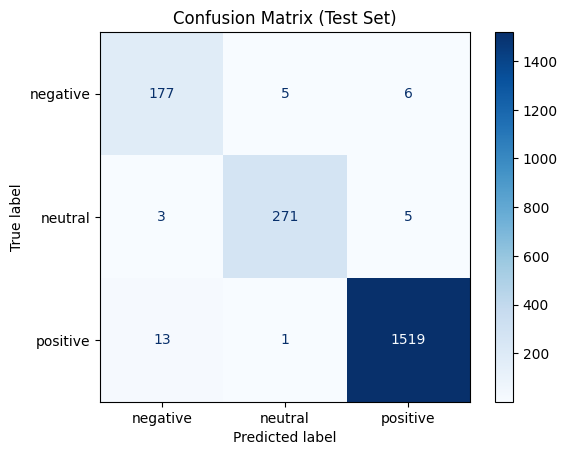


=== Top 15 Most Important Features ===
                     feature  importance
   rating_sentiment_mismatch    0.637497
             recommended_ind    0.138777
              extreme_rating    0.066337
       is_moderate_sentiment    0.036963
quality_negative_interaction    0.009394
             aspect_shipping    0.007062
comfort_positive_interaction    0.006387
              vader_compound    0.005765
  style_negative_interaction    0.005168
     price_vader_interaction    0.004645
    fit_negative_interaction    0.004576
comfort_negative_interaction    0.004505
         negative_word_count    0.003960
          neutral_indicators    0.003731
              aspect_comfort    0.003590


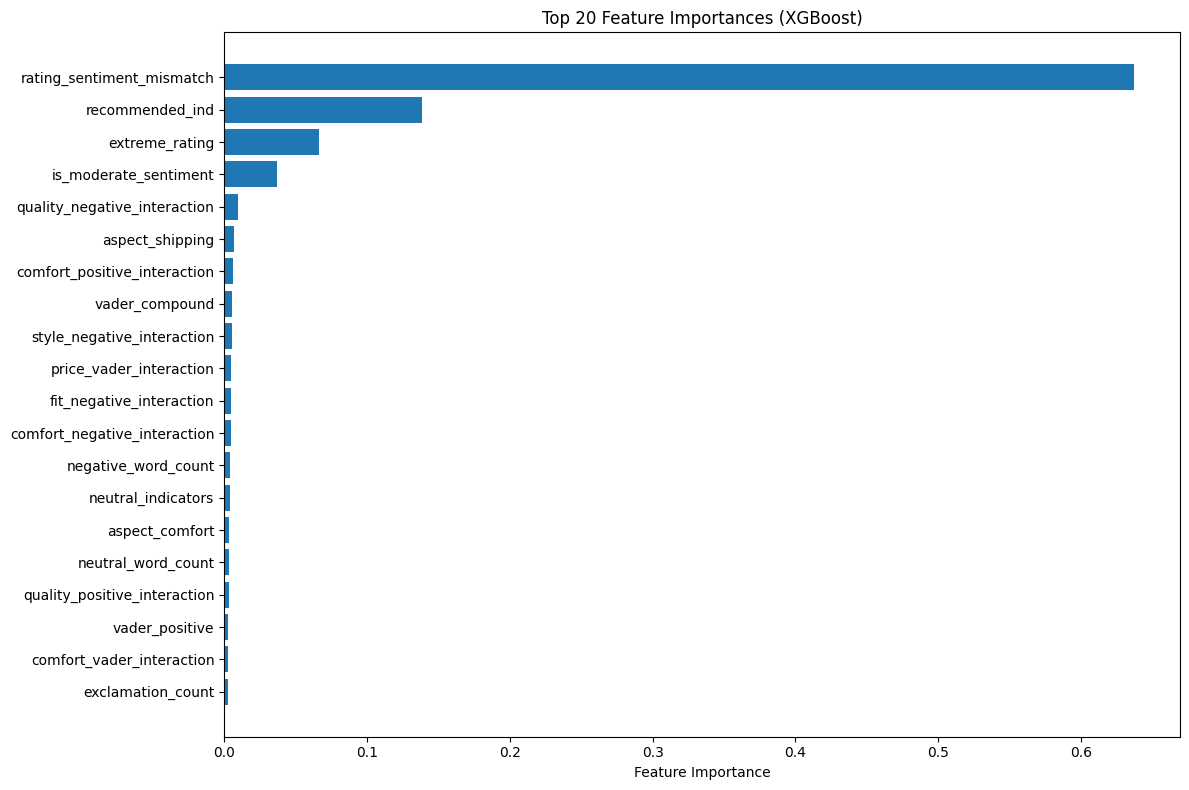


=== SHAP Analysis ===


SHAP analysis error: only integer scalar arrays can be converted to a scalar index


<Figure size 1200x800 with 0 Axes>

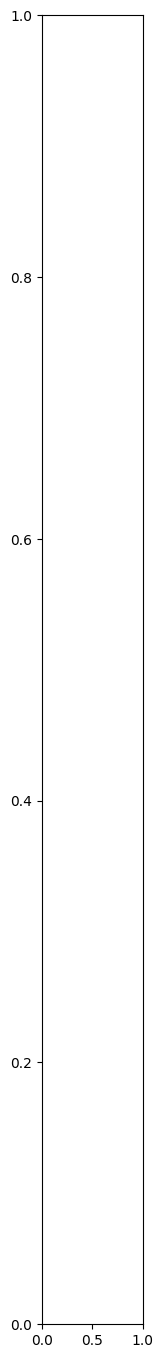

In [6]:
# ABSA XGBoost Tabular Pipeline: Exclude TF-IDF and Embedding Features from Importance/SHAP

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, re, optuna
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb
import shap
from textstat import flesch_reading_ease, flesch_kincaid_grade
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

warnings.filterwarnings('ignore')

try:
    nltk.data.find('vader_lexicon')
except LookupError:
    nltk.download('vader_lexicon', quiet=True)

class BusinessInsightExtractor:
    def __init__(self):
        self.aspects = {
            'fit': ['fit', 'size', 'tight', 'loose', 'small', 'large', 'sizing', 'fits', 'fitted'],
            'quality': ['quality', 'material', 'fabric', 'cheap', 'durable', 'well-made', 'construction', 'sturdy'],
            'style': ['style', 'color', 'design', 'fashionable', 'trendy', 'cute', 'beautiful', 'attractive'],
            'comfort': ['comfort', 'comfortable', 'soft', 'breathable', 'cozy', 'comfy', 'pleasant'],
            'price': ['price', 'expensive', 'cheap', 'value', 'worth', 'cost', 'money', 'affordable'],
            'shipping': ['shipping', 'delivery', 'arrived', 'fast', 'slow', 'package', 'quick']
        }
        self.positive_words = ['love', 'great', 'excellent', 'amazing', 'perfect', 'wonderful', 'fantastic', 'awesome']
        self.negative_words = ['hate', 'terrible', 'awful', 'horrible', 'worst', 'bad', 'poor', 'disappointing']
        self.neutral_words = ['okay', 'average', 'decent', 'normal', 'standard', 'typical', 'regular', 'fine']

    def generate_business_recommendations(self, df):
        print("\n=== BUSINESS INSIGHTS & RECOMMENDATIONS ===")
        for aspect in self.aspects.keys():
            aspect_col = f'aspect_{aspect}'
            if aspect_col in df.columns:
                aspect_mentions = df[aspect_col].sum()
                negative_mentions = df[(df[aspect_col]) & (df['sentiment'] == 'negative')].shape[0]
                neutral_mentions = df[(df[aspect_col]) & (df['sentiment'] == 'neutral')].shape[0]
                if aspect_mentions > 0:
                    negative_rate = negative_mentions / aspect_mentions * 100
                    neutral_rate = neutral_mentions / aspect_mentions * 100
                    print(f"• {aspect.upper()}: {aspect_mentions} mentions, {negative_rate:.1f}% negative, {neutral_rate:.1f}% neutral")
        return {"status": "completed"}

def executive_summary(df):
    print("\n=== EXECUTIVE SUMMARY ===")
    total_reviews = len(df)
    sentiment_dist = df['sentiment'].value_counts(normalize=True) * 100
    print(f"Total Reviews Analyzed: {total_reviews:,}")
    print("Sentiment Distribution:")
    for sentiment, pct in sentiment_dist.items():
        print(f"  • {sentiment.capitalize()}: {pct:.1f}%")
    avg_rating = df['rating'].mean()
    print(f"Average Rating: {avg_rating:.2f}/5")

def plot_overall_sentiment(df):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    sentiment_counts = df['sentiment'].value_counts()
    colors = ['#ff6b6b', '#ffd93d', '#6bcf7f']
    plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%',
            colors=colors, startangle=90)
    plt.title('Sentiment Distribution')
    plt.subplot(1, 3, 2)
    plt.hist(df['rating'], bins=5, color='skyblue', alpha=0.7, edgecolor='black')
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    plt.title('Rating Distribution')
    plt.xticks(range(1, 6))
    plt.subplot(1, 3, 3)
    rating_sentiment = df.groupby(['rating', 'sentiment']).size().unstack(fill_value=0)
    rating_sentiment.plot(kind='bar', stacked=True, color=colors, ax=plt.gca())
    plt.title('Rating vs Sentiment')
    plt.xlabel('Rating')
    plt.ylabel('Count')
    plt.legend(title='Sentiment')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

def plot_negative_aspect_breakdown(df):
    aspects = ['fit', 'quality', 'style', 'comfort', 'price', 'shipping']
    negative_counts, neutral_counts = [], []
    for aspect in aspects:
        aspect_col = f'aspect_{aspect}'
        if aspect_col in df.columns:
            neg_count = df[(df[aspect_col]) & (df['sentiment'] == 'negative')].shape[0]
            neu_count = df[(df[aspect_col]) & (df['sentiment'] == 'neutral')].shape[0]
            negative_counts.append(neg_count)
            neutral_counts.append(neu_count)
        else:
            negative_counts.append(0)
            neutral_counts.append(0)
    plt.figure(figsize=(12, 6))
    x = np.arange(len(aspects))
    width = 0.35
    plt.bar(x - width/2, negative_counts, width, label='Negative', color='#ff6b6b', alpha=0.7)
    plt.bar(x + width/2, neutral_counts, width, label='Neutral', color='#ffd93d', alpha=0.7)
    plt.title('Negative and Neutral Sentiment by Aspect')
    plt.xlabel('Aspects')
    plt.ylabel('Number of Reviews')
    plt.xticks(x, aspects, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_aspect_sentiment_heatmap(df):
    aspects = ['fit', 'quality', 'style', 'comfort', 'price', 'shipping']
    sentiments = ['negative', 'neutral', 'positive']
    heatmap_data = []
    for aspect in aspects:
        aspect_col = f'aspect_{aspect}'
        row = []
        for sentiment in sentiments:
            if aspect_col in df.columns:
                count = df[(df[aspect_col]) & (df['sentiment'] == sentiment)].shape[0]
                row.append(count)
            else:
                row.append(0)
        heatmap_data.append(row)
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data,
                xticklabels=sentiments,
                yticklabels=aspects,
                annot=True,
                fmt='d',
                cmap='RdYlBu_r',
                cbar_kws={'label': 'Number of Reviews'})
    plt.title('Aspect-Sentiment Heatmap')
    plt.xlabel('Sentiment')
    plt.ylabel('Aspects')
    plt.tight_layout()
    plt.show()

class ABSAXGBoostTabularPipeline:
    def __init__(self, max_train_samples=8000, max_test_samples=2000, n_splits=5, tfidf_max_features=200):
        self.label_encoder = LabelEncoder()
        self.scaler = StandardScaler()
        self.insight_extractor = BusinessInsightExtractor()
        self.max_train_samples = max_train_samples
        self.max_test_samples = max_test_samples
        self.n_splits = n_splits
        self.feature_cols = []
        self.sia = SentimentIntensityAnalyzer()
        self.tfidf_max_features = tfidf_max_features
        self.tfidf_vec = TfidfVectorizer(max_features=tfidf_max_features, stop_words='english')

    def load_and_preprocess_data(self):
        print("Loading dataset from Hugging Face...")
        try:
            from datasets import load_dataset
            dataset = load_dataset("Censius-AI/ECommerce-Women-Clothing-Reviews")
            df = pd.DataFrame(dataset["train"])
            print(f"Successfully loaded {len(df)} reviews from Hugging Face")
        except Exception as e:
            print(f"Dataset loading failed: {e}")
            print("Using synthetic fallback data...")
            return self._create_synthetic_data()
        df.columns = [col.strip().replace(' ', '_').lower() for col in df.columns]
        df = df.dropna(subset=['review_text'])
        df = df.sample(frac=1, random_state=42).reset_index(drop=True)
        train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['rating'])
        train_df = train_df.head(self.max_train_samples)
        test_df = test_df.head(self.max_test_samples)
        def create_sentiment_label(rating):
            if rating <= 2:
                return 'negative'
            elif rating == 3:
                return 'neutral'
            else:
                return 'positive'
        train_df['sentiment'] = train_df['rating'].apply(create_sentiment_label)
        test_df['sentiment'] = test_df['rating'].apply(create_sentiment_label)
        return train_df, test_df

    def _create_synthetic_data(self):
        print("Creating synthetic e-commerce review data...")
        np.random.seed(42)
        pos_tpl = ["Love this {item}! {aspect} is {positive_word}.", "Great {item}, perfect {aspect}.", "Excellent {aspect} and so {positive_word}."]
        neg_tpl = ["Poor {item}. {aspect} is {negative_word}.", "Terrible {aspect} on this {item}.", "Bad {aspect}, not recommended."]
        neu_tpl = ["Okay {item}. {aspect} is average.", "Normal {item}, {aspect} is fine.", "Typical {item}, decent {aspect}."]
        items = ["dress", "top", "blouse", "sweater", "jacket", "pants", "skirt"]
        aspects = ["fit", "quality", "style", "comfort", "fabric", "design"]
        pos_words = ["comfortable", "beautiful", "perfect", "excellent", "amazing"]
        neg_words = ["uncomfortable", "ugly", "poor", "terrible", "awful"]
        n_samples = self.max_train_samples + self.max_test_samples
        reviews, ratings = [], []
        for i in range(n_samples):
            rand = np.random.random()
            if rand < 0.6:  # positive
                review = np.random.choice(pos_tpl).format(item=np.random.choice(items), aspect=np.random.choice(aspects), positive_word=np.random.choice(pos_words))
                rating = np.random.choice([4, 5], p=[0.3, 0.7])
            elif rand < 0.8:  # neutral
                review = np.random.choice(neu_tpl).format(item=np.random.choice(items), aspect=np.random.choice(aspects))
                rating = 3
            else:  # negative
                review = np.random.choice(neg_tpl).format(item=np.random.choice(items), aspect=np.random.choice(aspects), negative_word=np.random.choice(neg_words))
                rating = np.random.choice([1, 2], p=[0.4, 0.6])
            reviews.append(review)
            ratings.append(rating)
        df = pd.DataFrame({'review_text': reviews, 'rating': ratings})
        train_df = df.iloc[:self.max_train_samples].copy()
        test_df = df.iloc[self.max_train_samples:self.max_train_samples + self.max_test_samples].copy()
        def create_sentiment_label(rating):
            if rating <= 2:
                return 'negative'
            elif rating == 3:
                return 'neutral'
            else:
                return 'positive'
        train_df['sentiment'] = train_df['rating'].apply(create_sentiment_label)
        test_df['sentiment'] = test_df['rating'].apply(create_sentiment_label)
        return train_df, test_df

    def extract_comprehensive_features(self, df, fit_tfidf=False):
        print("Extracting comprehensive features and TF-IDF...")
        aspects = self.insight_extractor.aspects
        for aspect, keywords in aspects.items():
            pattern = '|'.join([re.escape(kw) for kw in keywords])
            df[f'aspect_{aspect}'] = df['review_text'].str.lower().str.contains(pattern, na=False, regex=True).astype(int)
        df['text_length'] = df['review_text'].str.len()
        df['word_count'] = df['review_text'].str.split().str.len()
        df['sentence_count'] = df['review_text'].str.count(r'[.!?]+') + 1
        df['avg_word_length'] = df['review_text'].apply(lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0)
        df['flesch_reading_ease'] = df['review_text'].apply(lambda x: flesch_reading_ease(x) if len(x.split()) > 1 else 50)
        df['flesch_kincaid_grade'] = df['review_text'].apply(lambda x: flesch_kincaid_grade(x) if len(x.split()) > 1 else 5)
        sentiment_scores = df['review_text'].apply(lambda x: self.sia.polarity_scores(x))
        df['vader_compound'] = sentiment_scores.apply(lambda x: x['compound'])
        df['vader_positive'] = sentiment_scores.apply(lambda x: x['pos'])
        df['vader_negative'] = sentiment_scores.apply(lambda x: x['neg'])
        df['vader_neutral'] = sentiment_scores.apply(lambda x: x['neu'])
        positive_words = self.insight_extractor.positive_words
        negative_words = self.insight_extractor.negative_words
        neutral_words = self.insight_extractor.neutral_words
        def count_sentiment_words(text, word_list):
            text_lower = text.lower()
            return sum(1 for word in word_list if word in text_lower)
        df['positive_word_count'] = df['review_text'].apply(lambda x: count_sentiment_words(x, positive_words))
        df['negative_word_count'] = df['review_text'].apply(lambda x: count_sentiment_words(x, negative_words))
        df['neutral_word_count'] = df['review_text'].apply(lambda x: count_sentiment_words(x, neutral_words))
        df['exclamation_count'] = df['review_text'].str.count('!')
        df['question_count'] = df['review_text'].str.count(r'\?')
        df['capital_ratio'] = df['review_text'].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0)
        df['rating_sentiment_mismatch'] = ((df['rating'] == 3) & (df['vader_compound'].abs() > 0.1)).astype(int)
        df['extreme_rating'] = df['rating'].apply(lambda x: 1 if x in [1, 5] else 0)
        for aspect in aspects.keys():
            aspect_col = f'aspect_{aspect}'
            if aspect_col in df.columns:
                df[f'{aspect}_positive_interaction'] = df[aspect_col] * df['positive_word_count']
                df[f'{aspect}_negative_interaction'] = df[aspect_col] * df['negative_word_count']
                df[f'{aspect}_vader_interaction'] = df[aspect_col] * df['vader_compound']
        df['is_moderate_sentiment'] = ((df['vader_compound'] >= -0.1) & (df['vader_compound'] <= 0.1)).astype(int)
        df['balanced_sentiment'] = ((df['positive_word_count'] > 0) & (df['negative_word_count'] > 0)).astype(int)
        df['short_review'] = (df['word_count'] <= 5).astype(int)
        df['neutral_indicators'] = df['neutral_word_count'] + df['is_moderate_sentiment'] + df['balanced_sentiment']

        # TF-IDF Features
        if fit_tfidf:
            tfidf_matrix = self.tfidf_vec.fit_transform(df['review_text'])
        else:
            tfidf_matrix = self.tfidf_vec.transform(df['review_text'])
        tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=[f"tfidf_{i}" for i in range(self.tfidf_max_features)], index=df.index)
        df = pd.concat([df, tfidf_df], axis=1)

        # Select only numeric features for modeling and EXCLUDE all tfidf/emb columns
        exclude_cols = ['review_text', 'sentiment', 'rating']
        potential_features = [
            col for col in df.columns
            if col not in exclude_cols and
               not col.startswith("tfidf_") and
               not col.startswith("emb_")
        ]
        numeric_features = [col for col in potential_features if pd.api.types.is_numeric_dtype(df[col])]
        self.feature_cols = numeric_features
        return df

    def compute_sample_weights(self, y):
        from sklearn.utils.class_weight import compute_class_weight
        classes = np.unique(y)
        class_weights = compute_class_weight('balanced', classes=classes, y=y)
        neutral_class_idx = np.where(classes == 1)[0][0] if 1 in classes else None
        if neutral_class_idx is not None:
            class_weights[neutral_class_idx] *= 1.5
        weights = np.zeros_like(y, dtype=float)
        for idx, cls in enumerate(classes):
            weights[y == cls] = class_weights[idx]
        return weights

    def fit(self):
        print("Starting ABSA XGBoost (Tabular Features Only) Pipeline...")
        train_df, test_df = self.load_and_preprocess_data()
        train_df = self.extract_comprehensive_features(train_df, fit_tfidf=True)
        test_df = self.extract_comprehensive_features(test_df, fit_tfidf=False)
        executive_summary(train_df)
        plot_overall_sentiment(train_df)
        plot_negative_aspect_breakdown(train_df)
        plot_aspect_sentiment_heatmap(train_df)
        self.insight_extractor.generate_business_recommendations(train_df)
        y = self.label_encoder.fit_transform(train_df['sentiment'])
        y_test = self.label_encoder.transform(test_df['sentiment'])
        X = train_df[self.feature_cols].values
        X_test = test_df[self.feature_cols].values
        X = self.scaler.fit_transform(X)
        X_test = self.scaler.transform(X_test)
        feature_names = self.feature_cols
        skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        train_idx, val_idx = next(skf.split(X, y))
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        weights_train = self.compute_sample_weights(y_train)
        def objective(trial):
            param = {
                "objective": "multi:softprob",
                "num_class": 3,
                "eval_metric": "mlogloss",
                "max_depth": trial.suggest_int("max_depth", 3, 8),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
                "n_estimators": trial.suggest_int("n_estimators", 100, 500),
                "subsample": trial.suggest_float("subsample", 0.7, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
                "gamma": trial.suggest_float("gamma", 0, 5),
                "lambda": trial.suggest_float("lambda", 1e-3, 10.0, log=True),
                "alpha": trial.suggest_float("alpha", 1e-3, 10.0, log=True),
                "min_child_weight": trial.suggest_int("min_child_weight", 1, 7),
                "tree_method": "auto",
                "use_label_encoder": False,
                "verbosity": 0,
                "random_state": 42
            }
            model = xgb.XGBClassifier(**param)
            model.fit(X_train, y_train, sample_weight=weights_train)
            preds = np.argmax(model.predict_proba(X_val), axis=1)
            _, _, f1, _ = precision_recall_fscore_support(y_val, preds, average='weighted', zero_division=0)
            return 1.0 - f1
        print("Optuna tuning (optimizing for weighted F1 score)...")
        study = optuna.create_study(direction="minimize")
        study.optimize(objective, n_trials=20, show_progress_bar=False)
        best_params = study.best_trial.params
        best_params.update({
            "objective": "multi:softprob",
            "num_class": 3,
            "use_label_encoder": False,
            "tree_method": "auto",
            "random_state": 42
        })
        print("Best params:", best_params)
        oof_preds = np.zeros((len(y), 3))
        cv_acc, cv_prec, cv_rec, cv_f1 = [], [], [], []
        cv_neutral_f1 = []
        for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            print(f"Fold {fold+1}/{self.n_splits}...")
            X_tr, X_val = X[train_idx], X[val_idx]
            y_tr, y_val = y[train_idx], y[val_idx]
            weights = self.compute_sample_weights(y_tr)
            model = xgb.XGBClassifier(**best_params)
            model.fit(X_tr, y_tr, sample_weight=weights)
            val_pred = np.argmax(model.predict_proba(X_val), axis=1)
            oof_preds[val_idx] = model.predict_proba(X_val)
            acc = accuracy_score(y_val, val_pred)
            prec, rec, f1, _ = precision_recall_fscore_support(y_val, val_pred, average='weighted', zero_division=0)
            prec_per_class, rec_per_class, f1_per_class, _ = precision_recall_fscore_support(y_val, val_pred, average=None, zero_division=0)
            neutral_f1 = f1_per_class[1] if len(f1_per_class) > 1 else 0
            cv_acc.append(acc)
            cv_prec.append(prec)
            cv_rec.append(rec)
            cv_f1.append(f1)
            cv_neutral_f1.append(neutral_f1)
            print(f"  Fold acc: {acc:.4f}, prec: {prec:.4f}, rec: {rec:.4f}, f1: {f1:.4f}, neutral_f1: {neutral_f1:.4f}")
        print("\n=== Cross-Validation Results ===")
        print(f"Accuracy: {np.mean(cv_acc):.4f} ± {np.std(cv_acc):.4f}")
        print(f"Precision: {np.mean(cv_prec):.4f} ± {np.std(cv_prec):.4f}")
        print(f"Recall: {np.mean(cv_rec):.4f} ± {np.std(cv_rec):.4f}")
        print(f"F1: {np.mean(cv_f1):.4f} ± {np.std(cv_f1):.4f}")
        print(f"Neutral F1: {np.mean(cv_neutral_f1):.4f} ± {np.std(cv_neutral_f1):.4f}")
        sample_weights = self.compute_sample_weights(y)
        final_model = xgb.XGBClassifier(**best_params)
        final_model.fit(X, y, sample_weight=sample_weights)
        preds = np.argmax(final_model.predict_proba(X_test), axis=1)
        print("\n=== Test Results (Hold-out Set) ===")
        print(classification_report(y_test, preds, target_names=self.label_encoder.classes_))
        acc = accuracy_score(y_test, preds)
        prec, rec, f1, _ = precision_recall_fscore_support(y_test, preds, average='weighted')
        print(f"\nWeighted Metrics - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
        prec_per_class, rec_per_class, f1_per_class, support = precision_recall_fscore_support(y_test, preds, average=None, zero_division=0)
        print("\nPer-class Metrics:")
        for i, class_name in enumerate(self.label_encoder.classes_):
            print(f"{class_name}: Precision={prec_per_class[i]:.4f}, Recall={rec_per_class[i]:.4f}, F1={f1_per_class[i]:.4f}, Support={support[i]}")
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.label_encoder.classes_)
        disp.plot(cmap="Blues")
        plt.title("Confusion Matrix (Test Set)")
        plt.show()
        importances = final_model.feature_importances_
        importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values(by="importance", ascending=False)
        print(f"\n=== Top 15 Most Important Features ===")
        print(importance_df.head(15).to_string(index=False))
        plt.figure(figsize=(12, 8))
        top_features = importance_df.head(20)
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Feature Importance')
        plt.title('Top 20 Feature Importances (XGBoost)')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        try:
            print("\n=== SHAP Analysis ===")
            explainer = shap.TreeExplainer(final_model)
            shap_values = explainer.shap_values(X_test)
            plt.figure(figsize=(12, 8))
            shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False, max_display=20)
            plt.title("SHAP Feature Importance Summary")
            plt.tight_layout()
            plt.show()
            shap_importance = np.mean(np.abs(shap_values), axis=0)
            shap_importance_df = pd.DataFrame({'feature': feature_names, 'shap_importance': shap_importance}).sort_values(by="shap_importance", ascending=False)
            print("Top 15 Features by SHAP Importance:")
            print(shap_importance_df.head(15).to_string(index=False))
        except Exception as e:
            print(f"SHAP analysis error: {e}")
            shap_values = None
            shap_importance_df = None
        test_df["predicted_sentiment"] = self.label_encoder.inverse_transform(preds)
        return {
            "model": final_model,
            "label_encoder": self.label_encoder,
            "scaler": self.scaler,
            "test_df": test_df,
            "train_df": train_df,
            "feature_importance": importance_df,
            "shap_values": shap_values,
            "shap_importance": shap_importance_df if 'shap_importance_df' in locals() else None,
            "feature_names": feature_names,
            "cv_metrics": {
                "accuracy": cv_acc,
                "precision": cv_prec,
                "recall": cv_rec,
                "f1": cv_f1,
                "neutral_f1": cv_neutral_f1
            }
        }

if __name__ == "__main__":
    pipeline = ABSAXGBoostTabularPipeline()
    results = pipeline.fit()
